In [ ]:
!pip install torch torchvision matplotlib tqdm


In [ ]:
import torch, torch.nn as nn, torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## EDA

In [ ]:
stl_train = torchvision.datasets.STL10(root="./data", split="train", download=True)

In [ ]:
print("Total training examples:", len(stl_train))
print("Number of classes:", len(stl_train.classes))
print("Classes:", stl_train.classes)

Total training examples: 5000
Number of classes: 10
Classes: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


Data Size: (96, 96, 3) Label: 1 -> bird


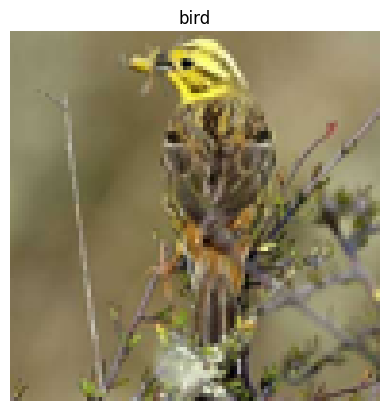

In [ ]:
img, label = stl_train[0]
print("Data Size:", np.array(img).shape, "Label:", label, "->", stl_train.classes[label])
plt.imshow(img)
plt.title(stl_train.classes[label])
plt.axis("off")
plt.show()

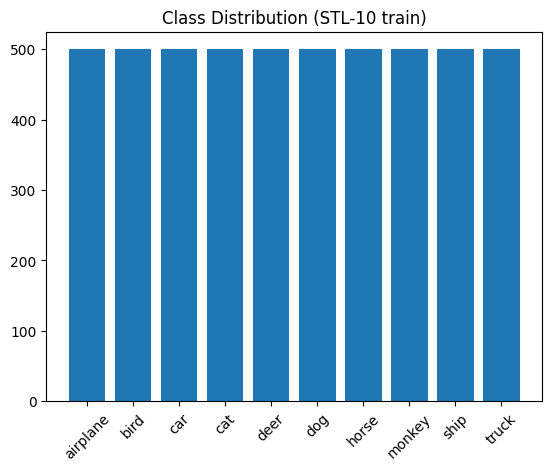

In [ ]:
labels = [lab for _, lab in stl_train]
cnt = Counter(labels)
plt.bar(range(len(stl_train.classes)), [cnt[i] for i in range(10)])
plt.xticks(range(10), stl_train.classes, rotation=45)
plt.title("Class Distribution (STL-10 train)")
plt.show()

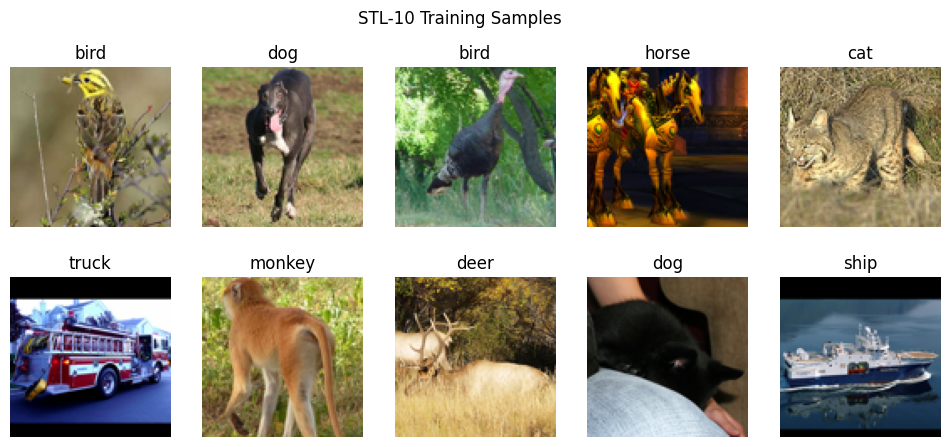

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(12,5))
for i, ax in enumerate(axes.flat):
    img, lab = stl_train[i]
    ax.imshow(img)
    ax.set_title(stl_train.classes[lab])
    ax.axis("off")
plt.suptitle("STL-10 Training Samples")
plt.show()

## Model And Data Load

##### Transform Method

In [ ]:
class TwoCropsTransform:
    def __init__(self, base_transform):
        self.base_transform = base_transform
    def __call__(self, x):
        return self.base_transform(x), self.base_transform(x)

simclr_transform = TwoCropsTransform(
    transforms.Compose([
        transforms.RandomResizedCrop(96, scale=(0.2, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(0.4,0.4,0.4,0.1),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1,2.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.4467,0.4398,0.4066),(0.2241,0.2215,0.2239)),
    ])
)


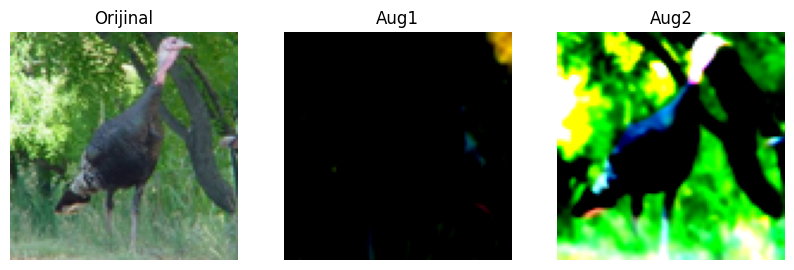

In [ ]:

augmented = TwoCropsTransform(simclr_transform)

img, _ = stl_train[2]
x1, x2 = augmented(img)

fig, axes = plt.subplots(1, 3, figsize=(10,4))
axes[0].imshow(img); axes[0].set_title("Orijinal"); axes[0].axis("off")
axes[1].imshow(np.transpose(x1.numpy(), (1,2,0))); axes[1].set_title("Aug1"); axes[1].axis("off")
axes[2].imshow(np.transpose(x2.numpy(), (1,2,0))); axes[2].set_title("Aug2"); axes[2].axis("off")
plt.show()


##### Load Data

In [ ]:
class STL10Pair(Dataset):
    """STL-10 dataset, her örnek için iki augment edilmiş tensor döndürür."""
    def __init__(self, root="./data", split="unlabeled", transform=None):
        self.dataset = torchvision.datasets.STL10(root=root, split=split, download=True)
        self.transform = transform
    def __len__(self): return len(self.dataset)
    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        if self.transform:
            xi, xj = self.transform(img)
            return xi, xj
        return img

def collate_fn(batch):
    xi = [item[0] for item in batch]
    xj = [item[1] for item in batch]
    return torch.stack(xi), torch.stack(xj)

train_unlabeled = STL10Pair(root="./data", split="unlabeled", transform=simclr_transform)
train_loader = DataLoader(train_unlabeled, batch_size=256, shuffle=True,
                          num_workers=2, drop_last=True, collate_fn=collate_fn)

print("Batch örneği:", next(iter(train_loader))[0].shape)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c012b51c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
      Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c012b51c0>^^
^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
^^
    if w.is_alive():  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive

     assert self._parent_pid == os.getpid(), 'can only test a child process' 
           ^^ ^ ^ ^ ^^ ^^^^^^^^^^
^  File

Batch örneği: torch.Size([256, 3, 96, 96])


In [ ]:
class ProjectionMLP(nn.Module):
    def __init__(self, in_dim=512, hidden=2048, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(inplace=True),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x): return self.net(x)

class SimCLR(nn.Module):
    def __init__(self, proj_dim=128):
        super().__init__()
        base = resnet18(weights=None)
        base.fc = nn.Identity()
        self.encoder = base
        self.projector = ProjectionMLP(512, 2048, proj_dim)
    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h), dim=-1)
        return h, z

model = SimCLR().to(device)
print("Toplam parametre (M):", sum(p.numel() for p in model.parameters())/1e6)


Toplam parametre (M): 12.489408


In [ ]:
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temp = temperature
    def forward(self, z_i, z_j):
        B = z_i.size(0)
        z = torch.cat([z_i, z_j], dim=0)
        sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=-1)
        mask = torch.eye(2*B, dtype=torch.bool, device=z.device)
        sim = sim.masked_fill(mask, -9e15)
        logits = sim / self.temp
        labels = torch.cat([torch.arange(B,2*B), torch.arange(0,B)]).to(z.device)
        return F.cross_entropy(logits, labels)


Epoch 1:   0%|          | 0/390 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c012b51c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0c012b51c0>  
  Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    ^if w.is_alive():^
^ ^ ^ ^ ^ ^
    File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^^assert self._parent_pid == os.getpid(), 'can only test a 

Epoch 1 | Loss: 5.1544


Epoch 2: 100%|██████████| 390/390 [10:19<00:00,  1.59s/it]


Epoch 2 | Loss: 4.9406


Epoch 3: 100%|██████████| 390/390 [10:09<00:00,  1.56s/it]


Epoch 3 | Loss: 4.8717


Epoch 4: 100%|██████████| 390/390 [10:22<00:00,  1.60s/it]


Epoch 4 | Loss: 4.8260


Epoch 5: 100%|██████████| 390/390 [10:12<00:00,  1.57s/it]


Epoch 5 | Loss: 4.7986


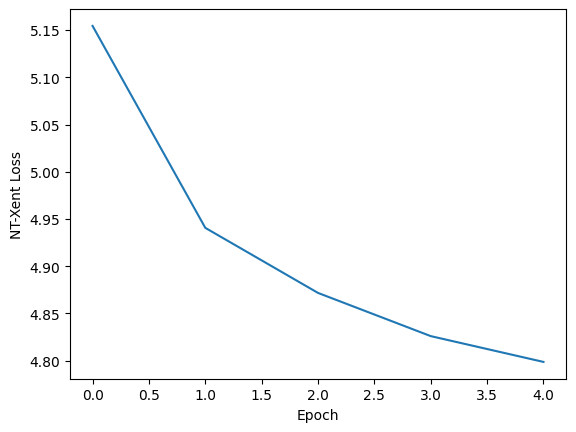

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
criterion = NTXentLoss(0.5).to(device)

losses = []
for epoch in range(5):  # deneme için 5 epoch
    run_loss = 0
    for xi, xj in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        xi, xj = xi.to(device), xj.to(device)
        _, zi = model(xi)
        _, zj = model(xj)
        loss = criterion(zi, zj)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        run_loss += loss.item()
    avg_loss = run_loss/len(train_loader)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    losses.append(avg_loss)

plt.plot(losses); plt.xlabel("Epoch"); plt.ylabel("NT-Xent Loss"); plt.show()


In [ ]:
# Encoder'ı dondur
for p in model.encoder.parameters():
    p.requires_grad = False
model.encoder.eval()

eval_tf = transforms.Compose([
    transforms.Resize(96),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize((0.4467,0.4398,0.4066),(0.2241,0.2215,0.2239)),
])

train_eval = torchvision.datasets.STL10(root="./data", split="train", download=True, transform=eval_tf)
test_eval  = torchvision.datasets.STL10(root="./data", split="test",  download=True, transform=eval_tf)

train_loader_eval = DataLoader(train_eval, batch_size=256, shuffle=False)
test_loader_eval  = DataLoader(test_eval,  batch_size=256, shuffle=False)

# Özellik çıkarma
def extract_features(loader):
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            h, _ = model(x.to(device))
            feats.append(h.cpu())
            labels.append(y)
    return torch.cat(feats), torch.cat(labels)

X_train, y_train = extract_features(train_loader_eval)
X_test, y_test   = extract_features(test_loader_eval)

# Linear classifier
linear = nn.Linear(512, 10).to(device)
opt = torch.optim.Adam(linear.parameters(), lr=1e-3)
ce = nn.CrossEntropyLoss()

for epoch in range(10):
    logits = linear(X_train.to(device))
    loss = ce(logits, y_train.to(device))
    opt.zero_grad(); loss.backward(); opt.step()
    print(f"Linear epoch {epoch+1} | loss={loss.item():.4f}")

# Test accuracy
with torch.no_grad():
    preds = linear(X_test.to(device)).argmax(1).cpu()
    acc = (preds == y_test).float().mean().item()*100
print("Linear Probe Test Accuracy:", acc)


Linear epoch 1 | loss=2.4943
Linear epoch 2 | loss=2.2863
Linear epoch 3 | loss=2.1176
Linear epoch 4 | loss=1.9833
Linear epoch 5 | loss=1.8769
Linear epoch 6 | loss=1.7913
Linear epoch 7 | loss=1.7201
Linear epoch 8 | loss=1.6585
Linear epoch 9 | loss=1.6040
Linear epoch 10 | loss=1.5560
Linear Probe Test Accuracy: 44.850000739097595


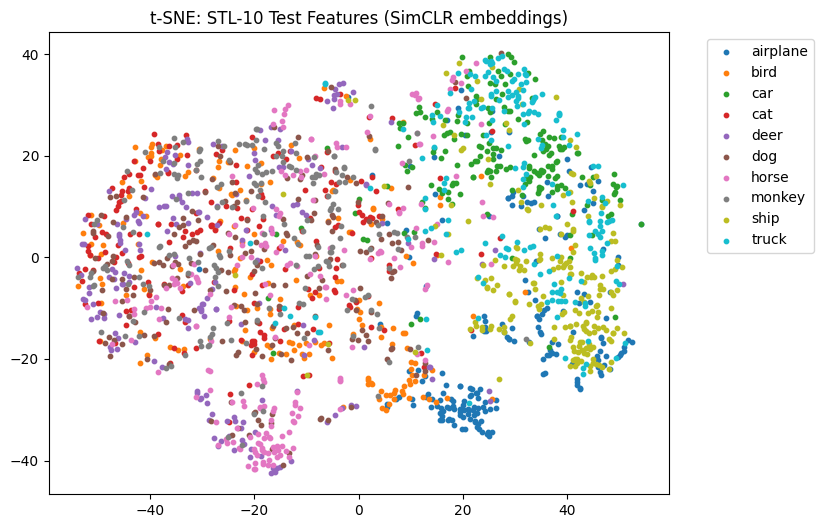

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Küçük subset (yoksa çok yavaşlar)
idx = torch.randperm(len(X_test))[:2000]
X_subset = X_test[idx].numpy()
y_subset = y_test[idx].numpy()

X_embedded = TSNE(n_components=2, perplexity=30, learning_rate="auto").fit_transform(X_subset)

plt.figure(figsize=(8,6))
for cls in np.unique(y_subset):
    pts = X_embedded[y_subset==cls]
    plt.scatter(pts[:,0], pts[:,1], s=10, label=train_eval.classes[cls])
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left")
plt.title("t-SNE: STL-10 Test Features (SimCLR embeddings)")
plt.show()


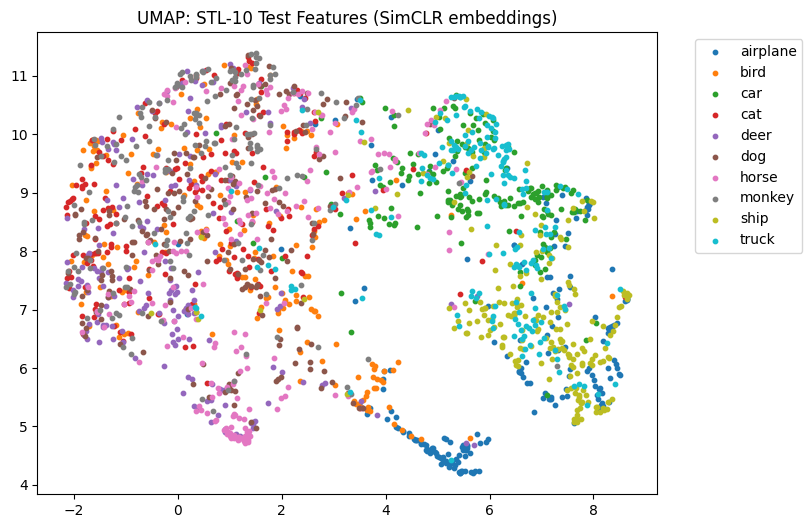

In [ ]:
!pip install umap-learn
import umap

reducer = umap.UMAP(n_components=2)
X_umap = reducer.fit_transform(X_subset)

plt.figure(figsize=(8,6))
for cls in np.unique(y_subset):
    pts = X_umap[y_subset==cls]
    plt.scatter(pts[:,0], pts[:,1], s=10, label=train_eval.classes[cls])
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("UMAP: STL-10 Test Features (SimCLR embeddings)")
plt.show()


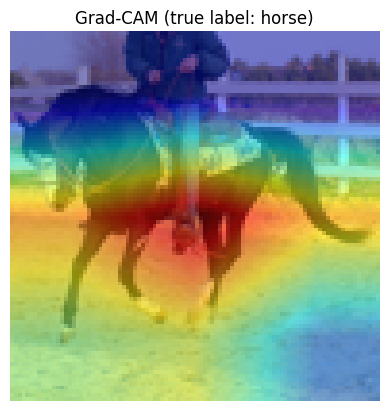

In [ ]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

# Örnek bir test resmi al
img, label = test_eval[0]
input_tensor = img.unsqueeze(0).to(device)

# Grad-CAM hedef katmanı = encoder’ın son conv bloğu
target_layers = [model.encoder.layer4[-1]]

# Temporarily enable gradients for the encoder
for param in model.encoder.parameters():
    param.requires_grad = True

cam = GradCAM(model=model.encoder, target_layers=target_layers)
grayscale_cam = cam(input_tensor=input_tensor, targets=None)[0]

# Restore original gradient settings
for param in model.encoder.parameters():
    param.requires_grad = False


# Görselleştir
rgb_img = np.transpose(img.numpy(), (1,2,0))
rgb_img = (rgb_img - rgb_img.min())/(rgb_img.max()-rgb_img.min())  # normalize
cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

plt.imshow(cam_image)
plt.title(f"Grad-CAM (true label: {train_eval.classes[label]})")
plt.axis("off")
plt.show()

Epoch 1 | loss=1.5145 | train_acc=45.18
Epoch 2 | loss=1.4791 | train_acc=46.42
Epoch 3 | loss=1.4489 | train_acc=46.80
Epoch 4 | loss=1.4230 | train_acc=47.84
Epoch 5 | loss=1.4007 | train_acc=48.56
Epoch 6 | loss=1.3813 | train_acc=49.42
Epoch 7 | loss=1.3647 | train_acc=49.76
Epoch 8 | loss=1.3505 | train_acc=50.52
Epoch 9 | loss=1.3384 | train_acc=50.72
Epoch 10 | loss=1.3281 | train_acc=50.94


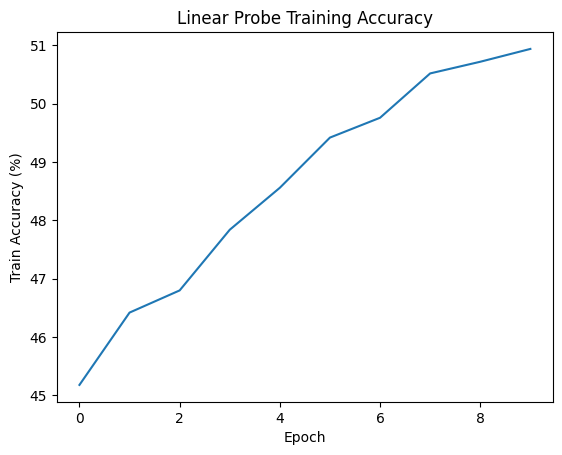

In [ ]:
train_accs = []
for epoch in range(10):
    logits = linear(X_train.to(device))
    loss = ce(logits, y_train.to(device))
    opt.zero_grad(); loss.backward(); opt.step()
    preds = logits.argmax(1).cpu()
    acc = (preds == y_train).float().mean().item()*100
    train_accs.append(acc)
    print(f"Epoch {epoch+1} | loss={loss.item():.4f} | train_acc={acc:.2f}")

plt.plot(train_accs)
plt.xlabel("Epoch"); plt.ylabel("Train Accuracy (%)")
plt.title("Linear Probe Training Accuracy")
plt.show()
